# Introduction

Hi! I'm Leo, an econ student and data sientist from Taiwan. In this notebook, we're going to explore the demand system, namely price elasticity, of Hass avocado using `Econml`.

The main issue of estimating treatment effects (price elasticity in this case) is how to solve endogeneity and get the correct, unbiased estimates. The basic problem of endogeneity occurs when the explanans (X) may be influenced by the explanandum (Y) or both may be jointly influenced by an unmeasured third. If we regress such Y on X , we may get a statistically significant but meaningless result.

Conventional ML algorithms like Random Forest or Gradient Boosting don't aim to solve this kind of problems, they explore correlations very well but fail on getting unbiased estimates. On the other hand, a lots of traditional econometrics models focus on this kind of problems, like 2SLS, IV, Regression on discontinuity (RD), Difference in Difference (DID), etc. The former two models rely on other variables which affect Y only through X, and the laters rely on some special data generation process. 

I encourage you if you think the abovementioned models can be apply on your data to get a causal relationship, however, most of the time we don't get the chance to apply those models by many restrictions. Therefore, we can't get the causal inferences which we want.

Today I want to share with you a very interesting model - Double/Debiased Machine Learning, which is used to measure the effectiveness of the policy. The original paper was published by Victor Chernozhukov (paper link), and Microsoft introduces the package `EconML` based on the method propused in this paper.

`EconML` offer large flexibility in modeling the effect heterogeneity (via techniques such as random forests, boosting, lasso and neural nets), while at the same time leverage techniques from causal inference and econometrics to preserve the causal interpretation of the learned model and many times also offer statistical validity via the construction of valid confidence intervals.

For more information please check the [Official Website](https://econml.azurewebsites.net/index.html).

# Table of contents
1. A Refresher on Price Elasticity
2. Loading the data
3. Introduction to DML 
4. All Markets Modeling
5. By region Modeling
6. Conclusion

# 1. A Refresher on Price Elasticity
## What is price elasticity?

The foundamental assumption in economics is that people will buy the product or service if it’s cheaper and less will buy it if it’s more expensive. But the phenomenon is more quantifiable than that, and price elasticity shows exactly how responsive customer demand is for a product based on its price. 

## How is it calculated?
Assuming that $Q$ is the quantity of demand for a certain commodity, and $P$ is the price of the commodity. Then the formula for price elasticity of demand:

$E_{d} = \frac{\Delta Q/Q}{\Delta P/P}$

Let’s look at an example. Say that a clothing company raised the price of one of its coats from \$100 to \$120. The price increase is $\frac{\$120-\$100}{\$100}$ or 20%. Now let’s say that the increase caused a decrease in the quantity sold from 1,000 coats to 900 coats. The percentage decrease in demand is -10%. Plugging those numbers into the formula, you’d get a price elasticity of demand of:

$E_{d} = \frac{\Delta Q/Q}{\Delta P/P} = \frac{-100/1000}{20/100} = - 0.5$

## 3. How to interpret price elasticity?

There are five zones of elasticity. Products and services can be:

* $E_{d}=0$：Perfectly Inelastic.

Where the quantity demanded does not change when the price changes. Products in this category are things consumers absolutely need and there are no other options from which to obtain them.

* $0<|E_{d}|<1$: Inelastic.

Where 1% of changes in price cause small changes in demand (less than 1%). Gasoline is a good example here because most people need it, so even when prices go up, demand doesn’t change greatly. Products with stronger brands tend to be more inelastic.

* $|E_{d}|=1$: Unitarily Elastic.

Where any 1% change in price is matched by an equal change in quantity (equal to 1%).

* $1<|E_{d}|<\infty$: Elastic.

Where 1% changes in price cause large changes in quantity demanded (greater than 1%). Beef is an example of a product that is relatively elastic.

* $E_{d}=\infty$: Perfectly Elastic.

Where any very small change in price results in a very large change in the quantity demanded. Products that fall in this category are mostly “pure commodities,” says Avery. “There’s no brand, no product differentiation, and customers have no meaningful attachment to the product.”

### References
* [Harvard Business Review](https://hbr.org/2015/08/a-refresher-on-price-elasticity)
* [Wiki](https://en.wikipedia.org/wiki/Price_elasticity_of_demand)

## So what do you think the price elasticity of avocado will be like? 
## Let’s go explore it !

In [ ]:
! pip install econml

In [ ]:
# If you can't run econml run this block to update your sciket learn
! pip install -U scikit-learn

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from functools import reduce
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [ ]:
# sklearn
from sklearn.linear_model import Lasso, MultiTaskLasso, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# To support SVM and XGB in estimating multi-dimensional outputs
from sklearn.multioutput import MultiOutputRegressor 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

#EconML
from econml.dml import LinearDMLCateEstimator, SparseLinearDMLCateEstimator

In [ ]:
# Load Data
df = pd.read_csv('../input/avocado-prices/avocado.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by = ['Date','region']).head()


## 2. Preprocessing

In [ ]:
# Prepare propriate dataset for estimation
# Use weighted average to calculate the 
wt_avg = lambda x: np.average(x, weights = df.loc[x.index, 'Total Volume'])

df1 = pd.pivot_table(
    df, 
    index = ['Date','region'], 
    columns = df.groupby(['Date','region']).cumcount(), 
    values = ['AveragePrice','Total Volume'],
    aggfunc= {'AveragePrice':wt_avg, 'Total Volume':'sum'}
).reset_index()
df1.head()

In [ ]:
# Rename columns
df1.columns = df1.columns.map('{0[0]}{0[1]}'.format) 
df1 = df1.rename(
        index = str,
        columns = {
            'AveragePrice0':'Price_conventional',
            'AveragePrice1':'Price_organic',
            'Total Volume0':'Volume_conventional',
            'Total Volume1':'Volume_organic'}
)
# Fill NA occurs in aggregation
FillNAValues = df1.groupby('Date')[['Price_organic','Volume_organic']].transform('mean')
df1[['Price_organic','Volume_organic']] = df1[['Price_organic','Volume_organic']].fillna(FillNAValues) 
df1.head()

In [ ]:
# Create lag Price and Volume by each type 
lag_variables = ['Price_conventional','Price_organic','Volume_conventional','Volume_organic']

df1 = df1.sort_values(by = 'Date')
for col in lag_variables:
    for i in [1,2,3]: 
        col_name = f"Lag{i}_{col}"
        df1[col_name] = df1.groupby('region')[col].shift(i)
df1 = df1.dropna()

# Separate Aggregated regions to avoid multi-collinearity
regional_data = df1[~df1['region'].isin(['Northeast','SouthCentral','Southeast','Midsouth','West','TotalUS'])]
regional_data.head()

# 3. Introduction to DML Modeling
## Orthogonal/Double Machine Learning (DML)
Here I am not going to cover the mathematical detail of the model, just to introduce how the model works and when should you use it. 

If you want to know more about DML, please check [Chernozhukov2016](https://arxiv.org/abs/1608.00060) or [EconML doc](https://econml.azurewebsites.net/spec/estimation/dml.html).

### What is it?
The general model:
$$Y =T\cdot\beta + g(W)+U, \,\,\, \mathbb{E}[U|T,W]=0$$

$$T = d(W) + V, \,\,\, E[V|W] = 0$$

Double Machine Learning is a method for estimating (heterogeneous) treatment effects when all potential confounders/controls (factors that simultaneously had a direct effect on the treatment decision and the observed outcome) are observed.

The method reduces the problem to first estimating two predictive tasks:

1. predicting the outcome from the controls,
2. predicting the treatment from the controls;

Then the method combines these two predictive models in a final stage estimation so as to create a model of the heterogeneous treatment efffect. 

The approach allows for arbitrary Machine Learning algorithms to be used for the two predictive tasks, such as random forests, lasso, deep neural nets, boosted trees, and various hybrids and ensembles of these methods. While maintaining many favorable statistical properties related to the final model (e.g. small mean squared error, asymptotic normality, construction of confidence intervals).

The following figure from [Chernozhukov2016](https://arxiv.org/abs/1608.00060) compares the results of adopting DML(right) and not adopting it(left) in a simulation experiment:
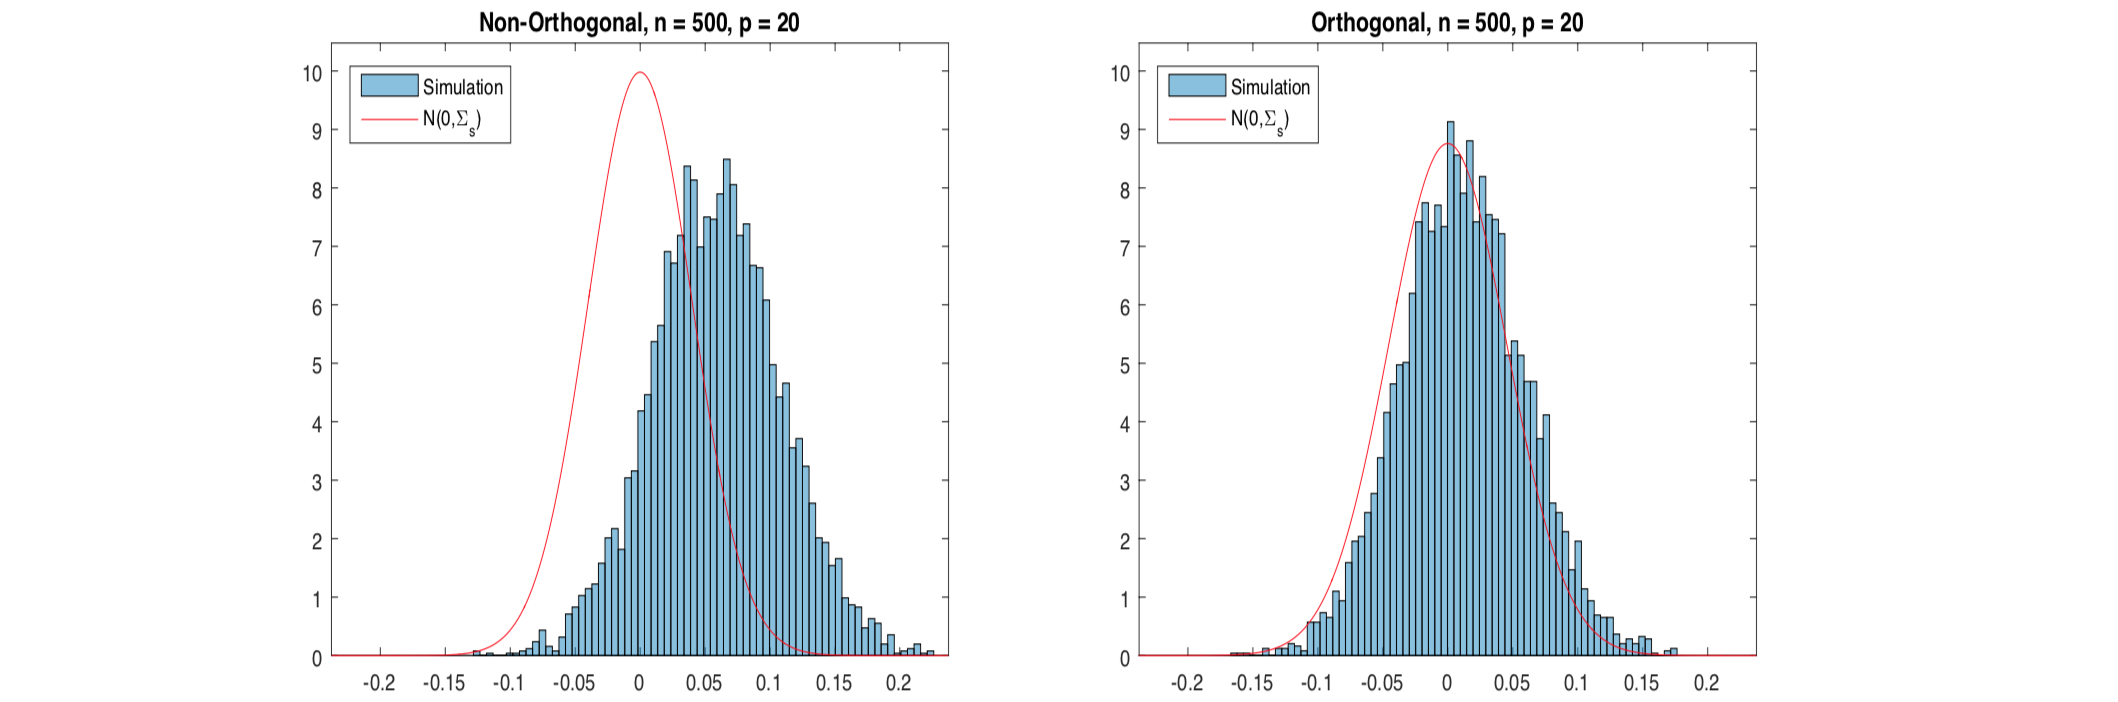
### When should you use it?

Assume we have data that are generated from some collection policy. In particular, we assume that we have data of the form: 
$\{Y_{i}(T_{i}), T_{i}, X_{i}, W_{i}, Z_{i}\}$, 
where 
* $Y_{i}(T_{i})$ is the observed outcome for the chosen treatment, 
* $T_{i}$ is the treatment, 
* $X_{i}$ are the covariates used for heterogeneity, 
* $W_{i}$ are other observable covariates that we believe are affecting the potential outcome $Y_{i}(T_{i})$ and potentially also the treatment $T_{i}$, 
* $Z_{i}$ are variables that affect the treatment $T_{i}$ but do not directly affect the potential outcome. 

We will refer to variables $W_{i}$ as controls and variables $Z_{i}$ as instruments. 
The variables $X_{i}$ can also be thought of as control variables, but they are special in the sense that they are
a subset of the controls with respect to which we want to measure treatment effect heterogeneity. 

### Prepare variables and normalize data

In [ ]:
scaler = StandardScaler()
Y = np.log(regional_data[['Volume_conventional','Volume_organic']])
P = np.log(regional_data[['Price_conventional','Price_organic']])

lag_price =  np.log(
        regional_data[['Lag1_Price_conventional', 'Lag2_Price_conventional','Lag3_Price_conventional','Lag1_Price_organic', 'Lag2_Price_organic','Lag3_Price_organic']]
)
lag_volume = np.log(
        regional_data[['Lag1_Volume_conventional', 'Lag2_Volume_conventional','Lag3_Volume_conventional','Lag1_Volume_organic', 'Lag2_Volume_organic','Lag3_Volume_organic']]
)

# Create polynominal features
Price_Volume = np.concatenate([lag_price, lag_volume], axis = 1)
poly = PolynomialFeatures(degree = 2)
Price_Volume = poly.fit_transform(Price_Volume)

# Year-Month pairs and region fixed effects
w_date = pd.get_dummies(regional_data['Date'].dt.to_period('M')).values #.dt.to_period('M')
w_region= pd.get_dummies(regional_data['region']).values

# Concatenate all the features
W = reduce(lambda x,y: np.concatenate([x,y], axis = 1), [Price_Volume, w_date, w_region]) #w_region

### How to build the model in this case?
Since the heterogeneity of price elasticities are not of my interest, so I ignore the heterogeneity variable $X_{i}$ and build the model base on the covriates $W$,
where $W$ include Year-Month pairs, regional fixed effects and 3 lagged realizations of the demand system $(Y_{i,t−l}, P_{i,t−l})_{i∈[I],\,\,l∈\{1,2\}}$, and interactions to maximize the predictive performance of the first stage ML models.

The (log) volumes are used as the dependent variable, $Y$ and log prices are used as used treatment variables, $T$.

### What will we get ?
Our model for demand system:
$$Log\,\,Q_{i,\,t} = Log\,\, P_{own,\,t}\cdot\theta_{own} +Log\,\, P_{other,\,t}\cdot\theta_{cross} + g(W_{i,t}) + \epsilon_{i,t}$$

$$Log\,\,P_{own,\,t} = d(W_{i,\,t}) + \mu_{i,t}$$

Where $i$ and $t$ together denote a unique combination of region and date.

Since the heterogeneity of price elasticities are not of my interest, so I ignore the heterogeneity variable $X_{i}$ and build the model base on the covriates $W$,
where $W$ include Year-Month pairs, regional fixed effects and 3 lagged realizations of the demand system $(Y_{i,t−l}, P_{i,t−l})_{i∈[I],\,\,l∈\{1,2\}}$, and interactions to maximize the predictive performance of the first stage ML models.
The (log) volumes are used as the dependent variable, $Log\,\,Q$ and log prices are used as used treatment variables, $Log\,\,P$.

The own-price elasticities and cross-price elasticities of avocado are $\theta_{own}$ and $\theta_{cross}$, respectively.

In the modeling section, I will implement technics such as OLS, Lasso, Random Forest, XGBoost and SVM as well as some mixed models(e.g. Random Forest + Lasso).

### Let's begin!

## 4. All Markets Modeling

In [ ]:
# OLS
est_ols = LinearDMLCateEstimator(
    model_y = LinearRegression(),
    model_t = LinearRegression(),
    n_splits = 5
)
est_ols.fit(Y, P, None, W, inference = 'statsmodels')
print('OLS MSE: {:.4f}'.format(est_ols.score(Y,P,None,W)))


# Lasso
est_lasso = LinearDMLCateEstimator(
    model_y = Lasso(alpha = 0.001),
    model_t = Lasso(alpha = 0.01),
    n_splits = 5
)
est_lasso.fit(Y, P, None, W, inference = 'statsmodels')
print('Lasso MSE: {:.4f}'.format(est_lasso.score(Y,P,None,W)))


# Randomforest
rf_y = RandomForestRegressor(
    bootstrap=True, n_estimators=300, n_jobs=-1, oob_score=True, random_state = 23
)
rf_t = RandomForestRegressor(
    bootstrap=True, n_estimators=300, n_jobs=-1, oob_score=True, random_state = 22
)
est_rf = LinearDMLCateEstimator(
    model_y = rf_y,
    model_t = rf_t,
    n_splits = 5
)
est_rf.fit(Y, P, None, W, inference = 'statsmodels')
print('RF MSE: {:.4f}'.format(est_rf.score(Y,P,None,W)))


#SVM
est_svm = LinearDMLCateEstimator(
    model_y = MultiOutputRegressor(SVR(kernel = 'linear', C = 0.1)),
    model_t = MultiOutputRegressor(SVR(kernel = 'linear', C = 0.1)), 
)
est_svm.fit(Y,P,None,W, inference = 'statsmodels')
print('SVM MSE: {:.4f}'.format(est_svm.score(Y,P,None,W)))


# Gradient Boosting
est_gbr = LinearDMLCateEstimator(
    model_y = MultiOutputRegressor(GradientBoostingRegressor()),
    model_t = MultiOutputRegressor(GradientBoostingRegressor()),
    n_splits = 5
)
est_gbr.fit(Y,P,None,W, inference = 'statsmodels')
print('GBR MSE: {:.4f}'.format(est_gbr.score(Y,P,None,W)))


# Lasso + Random Forest
est_mix1 = LinearDMLCateEstimator(
    model_y = Lasso(alpha = .001),
    model_t = rf_t,
    n_splits = 5
)
est_mix1.fit(Y, P, None, W, inference = 'statsmodels')
print('Mix1 MSE: {:.4f}'.format(est_mix1.score(Y,P,None,W)))


# Random Forest + Gradient Boosting
est_mix2 = LinearDMLCateEstimator(
    model_y = Lasso(alpha = .001),
    model_t = MultiOutputRegressor(GradientBoostingRegressor()),
    n_splits = 5
)
est_mix2.fit(Y, P, None, W, inference = 'statsmodels')
print('Mix2 MSE: {:.4f}'.format(est_mix2.score(Y,P,None,W)))

## Results Visualization

In [ ]:
models = [est_ols, est_lasso, est_rf, est_svm, est_gbr, est_mix1, est_mix2]
labels = ['OLS','Lasso','RF','SVM', 'GBR','Mix1', 'Mix2']
xlabels = ['Conventional','Organic']

fig, axes = plt.subplots(ncols=2, nrows=2, figsize = [12,12], dpi = 120)
for index, ax in enumerate(axes.flatten()):
    estmates = [model.const_marginal_effect()[0][index//2][index%2] for model in models]
    range_ = [model.const_marginal_effect_interval()[1][0][index//2][index%2] - model.const_marginal_effect_interval()[0][0][index//2][index%2] for model in models]
    tmp = pd.DataFrame({'estimtes':estmates,'range':range_}, index = labels).reset_index()
    for i in tmp.index:
        ax.errorbar(
            i, tmp.loc[i, 'estimtes'],
            yerr = tmp.loc[i, 'range']/2,
            fmt = 'o', ms = 8, mfc = 'white', elinewidth = 3, capsize= 8)
    ax.set_xticklabels(['','OLS','Lasso','RF','SVM','GBR','Mix1','Mix2'])
    
plt.tight_layout()
axes[0,0].set_ylabel('% of  Conventional Volume Changed\n')
axes[0,0].set_title('1% Price Increase of Conventional')
axes[0,1].set_title('1% Price Increase of Organic')
axes[1,0].set_ylabel('% of  Organic  Changed\n')

Figures represents percentage of change in volume corresponds to 1% of change in the product price. For example the bottom left figure shows that if price of conventional avocado increase by 1%, the volume of organic avocado will increase by roughly 20% ~ 28%, which is the cross elasticity of conventional type to organic type avocado.

There are three key findings:

* **Price Sensitive**: The diagnal figures shows that the value of own price elasticities are around -1.35 and -1.43, repectly. Which suggest that consumers for both types of avocado are price sensitive. 

* **Asymmetric Substitution**: The bottom left figure represents the cross price elasticity of conventional avocado to organic avocado. The effects are consistently centered around 0.23 and statistically significant( 95% intervals didn't intersect with zero). On the other hand, The top right figure represents the cross price elasticity of organic avocados to conventional avocados. These estimated values are very close to zero, and some of them not statistically significant. 
In summary, consumers may substitude conventional avocados to organic avocados when the price of conventional avocado increases, but not in reverse direction.
Which suggest the subsitution effect from conventional to organic avocados  

* **SVM**: Considering mean estimates and confidence intervals, SVM seems to be the stablest model among all algorithms. Therefore, we will use it as base model in the next section.

# 5. Regional Market Modeling
To find out the regional demand system, I am going to run a separate estimation on each region. 

Use Random Forest as the base model:

In [ ]:
# define preprocessing function
def preprocess(data):
    scaler = StandardScaler()
    Y = np.log(data[['Volume_conventional','Volume_organic']])
    P = np.log(data[['Price_conventional','Price_organic']])
    lag_price = scaler.fit_transform(np.log(data[['Lag1_Price_conventional', 'Lag2_Price_conventional','Lag1_Price_organic', 'Lag2_Price_organic']]))
    lag_volume = scaler.fit_transform(np.log(data[['Lag1_Volume_conventional', 'Lag2_Volume_conventional','Lag1_Volume_organic', 'Lag2_Volume_organic']]))
    # Create polynominal features
    Price_Volume = np.concatenate([lag_price, lag_volume], axis = 1)
    poly = PolynomialFeatures(degree = 2)
    Price_Volume = poly.fit_transform(Price_Volume)
    w_date = pd.get_dummies(data['Date'].dt.to_period('M')).values
    W = np.concatenate([Price_Volume,w_date],axis = 1)
    return Y, P, W

In [ ]:
regions = df1['region'].unique()

est_conventional, conventional_interval_range = [], []
est_organic, organic_interval_range = [], []

# Estimate  
for r in tqdm(regions):
    data = df1[df1['region'] == r]
    
    Y,P,W = preprocess(data)
    
    # Use SparseLinearDMLCateEstimator
    est = LinearDMLCateEstimator(
        model_y = MultiOutputRegressor(SVR(kernel = 'linear', C = 0.1)),
        model_t = MultiOutputRegressor(SVR(kernel = 'linear', C = 0.1)), 
        n_splits = 3
    )

    est.fit(Y,P, None, W, inference = 'statsmodels')
    est_conventional.append(est.const_marginal_effect()[0,0,0])
    cont_interval = est.const_marginal_effect_interval()[1][0][0][0] - est.const_marginal_effect_interval()[0][0][0][0]
    conventional_interval_range.append(cont_interval)

    est_organic.append(est.const_marginal_effect()[0,1,1])
    organic_interval = est.const_marginal_effect_interval()[1][0][1][1] - est.const_marginal_effect_interval()[0][0][1][1]
    organic_interval_range.append(organic_interval)

In [ ]:
# 
conventional = pd.DataFrame(
    {'region':regions, 'Elasticity':est_conventional, 'ci_range':conventional_interval_range}
)

organic = pd.DataFrame(
     {'region':regions, 'Elasticity':est_organic, 'ci_range':organic_interval_range}
)

In [ ]:
# arrange both dataset by organic avocado's elasticity 
organic  = organic.sort_values(by = 'Elasticity')
conventional = conventional.set_index('region').loc[organic['region']].reset_index()

coordinates = np.arange(len(organic['region']))

fig, ax = plt.subplots(figsize = [25,7], dpi = 150)
ax.errorbar(
    organic['region'],
    organic['Elasticity'],   #conventional['region']
    yerr = organic['ci_range']/2,
    ecolor = '#461881', mfc = 'white', mec = '#461881',fmt='o', label = 'Organic')
ax.errorbar(coordinates+0.2,
    conventional['Elasticity'], 
    yerr = conventional['ci_range']/2,
    ecolor = '#F9016F', mfc = 'white', mec = '#F9016F',fmt='o', label = 'Conventional')

# Highlight aggregated regions
ax.get_xticklabels()[10].set_weight('bold')
ax.get_xticklabels()[28].set_weight('bold')
ax.get_xticklabels()[30].set_weight('bold')
ax.get_xticklabels()[36].set_weight('bold')
ax.get_xticklabels()[44].set_weight('bold')
ax.get_xticklabels()[51].set_weight('bold')

plt.ylabel('Own-Price Elasticity\n', fontsize = 20)
plt.yticks(fontsize = 15)
plt.yticks(fontsize = 12)
plt.gca().invert_yaxis()

plt.xticks(rotation = 90, fontsize = 15)
plt.grid(axis = 'y')
plt.legend(fontsize = 15)

It is worth noting that the means and confidence intervals in regional estimation are much more larger compare to the overall estimates. It may dut to model can't learn the relatively small data points (which is 166 for each region) very well, so the estimates are upward biased. You can also find that the price elasticity of organic avocado in Northen New England is positive, which is certainly againsts our economic intuition. However, it is still worth to compare price sensitivities between regions.
 ### Key Findings
1. Demand for conventional avocados appears to be consistent across markets, the price elasticities are centered around -1.3 with small 95% confidence intervals. 
2. Demand for organic avocados seems to be more volatile across markets, that could be result from many reasons. For example, smaller trading volumes, the choose for healthier life style or accessibility to other organic products, etc.

## Conclusion: What do we find ? 

Key findings from the avocados demand system analysis:
* **Picky Consumers**: Consumers are picky to price among markets (elastcity > 1), which make sense because avocados ain't necessity goods. People won't die if they don't eat avocados, they can wait until the price fall.
* **One way market**: The cross-price elasticity analysis shows that consumers would turn to organic avocados when the price of conventional avocados increases, but would not turn to conventional avocados when the price of organic avocados increases. We can conclude that organic avocado is substitution to conventional avocados, if prices of ordinary avocados become expensive, isn't it great for us to buy organic fruits ?